In [2]:
import torch
import numpy as np 
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Optimizer
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from useful_functions import *
from optimizer import *
from model import *
from MNIST_data_process import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from training import *
from mlxtend.data import mnist_data
from accuracy_compute import *
from data_preparation_easy import *
from data_preparation_hard import *
from network_func import *
from search_parameter import *
import optuna
from CIFAR10_model import *
from CIFAR10_data_preparation import *

In [3]:
n=5
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=di_ring(n=n)
A=R
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=cifar10_prepare_node_5_hard_shuffled()

A的第二大特征值: 4.790584196710678e-25
A的beta: 1.387778780781446e-16
A的spectral gap: 0.9999999999999999
A的kappa: 1.0000000000000002
S_A是: 4.472135954999581 

1.0000e+00, 5.0000e+00


In [10]:
from torchvision.models import resnet18
model_instance = resnet18(num_classes=10)

Sum_l1, Sum_a1 = train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=model_instance.__class__,#SimpleResNet1,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=20,
    lr=1e-3,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

TypeError: ResNet.__init__() missing 2 required positional arguments: 'block' and 'layers'

Training Progress: 100%|██████████| 500/500 [1:36:51<00:00, 11.62s/it, accuracy=39.0600000000%, epoch=500, loss=1.7025604010]


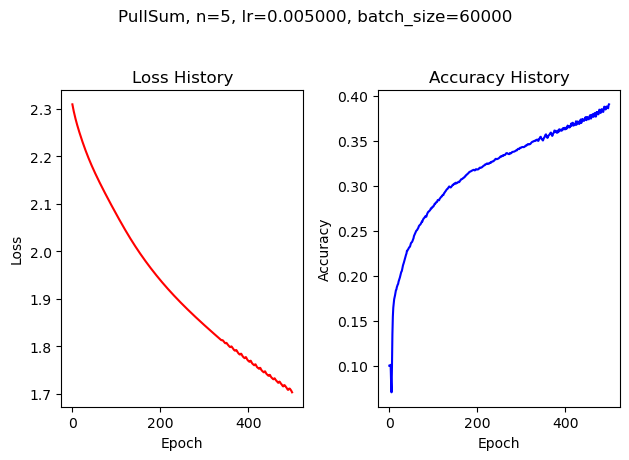

In [5]:
Sum_l2, Sum_a2 = new_train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=SimpleResNet1,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=1e-3,#0.14534766737788476,
    batch_size=60000,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

In [6]:
Sum_l3, Sum_a3 = new_train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=SimpleResNet1,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=500,
    lr=1e-3,#0.14534766737788476,
    batch_size=64,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

Training Progress:  16%|█▌        | 79/500 [1:04:44<5:44:59, 49.17s/it, accuracy=72.8200000000%, epoch=79, loss=0.7003954241]


KeyboardInterrupt: 